In [1]:
%matplotlib inline

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import argparse
import collections
import datetime


import backtrader as bt


class St(bt.SignalStrategy):
    params = (
        ('pfast', 13),
        ('pslow', 50),
        ('printdata', False),
        ('stake', 1000),
        ('short', False),
    )

    def __init__(self):
        self.sfast = bt.indicators.SMA(period=self.p.pfast)
        self.sslow = bt.indicators.SMA(period=self.p.pslow)
        self.cover = bt.indicators.CrossOver(self.sfast, self.sslow)
        if self.p.short:
            self.signal_add(bt.SIGNAL_LONGSHORT, self.cover)
        else:
            self.signal_add(bt.SIGNAL_LONG, self.cover)

    def start(self):
        super(self.__class__, self).start()
        if self.p.printdata:
            txtfields = list()
            txtfields.append('Len')
            txtfields.append('Datetime')
            txtfields.append('Open')
            txtfields.append('High')
            txtfields.append('Low')
            txtfields.append('Close')
            txtfields.append('Volume')
            txtfields.append('OpenInterest')
            print(','.join(txtfields))

    def next(self):
        super(self.__class__, self).next()
        if self.p.printdata:
            # Print only 1st data ... is just a check that things are running
            txtfields = list()
            txtfields.append('%04d' % len(self))
            txtfields.append(self.data.datetime.datetime(0).isoformat())
            txtfields.append('%.2f' % self.data0.open[0])
            txtfields.append('%.2f' % self.data0.high[0])
            txtfields.append('%.2f' % self.data0.low[0])
            txtfields.append('%.2f' % self.data0.close[0])
            txtfields.append('%.2f' % self.data0.volume[0])
            txtfields.append('%.2f' % self.data0.openinterest[0])
            print(','.join(txtfields))


_TFRAMES = collections.OrderedDict(
    (
        ('minutes', bt.TimeFrame.Minutes),
        ('days', bt.TimeFrame.Days),
        ('weeks', bt.TimeFrame.Weeks),
        ('months', bt.TimeFrame.Months),
        ('years', bt.TimeFrame.Years),
    )
)

_TFS = _TFRAMES.keys()


def runstrat(args=None):
    args = parse_args(args)

    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(args.cash)

    dkwargs = dict()
    if args.fromdate:
        fromdate = datetime.datetime.strptime(args.fromdate, '%Y-%m-%d')
        dkwargs['fromdate'] = fromdate

    if args.todate:
        todate = datetime.datetime.strptime(args.todate, '%Y-%m-%d')
        dkwargs['todate'] = todate

    if args.timeframe:
        dkwargs['timeframe'] = _TFRAMES[args.timeframe]

    if args.compression:
        dkwargs['compression'] = args.compression

    # data0 = bt.feeds.BacktraderCSVData(dataname=args.data0, **dkwargs)
    data0 = bt.feeds.VCData(dataname=args.data0, historical=True, **dkwargs)
    cerebro.adddata(data0, name='Data0')

    cerebro.addstrategy(St, short=args.short, printdata=args.printdata)
    cerebro.addsizer(bt.sizers.FixedSize, stake=args.stake)

    # Own analyzerset
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Years)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Years)
    cerebro.addanalyzer(bt.analyzers.SQN,)

    if args.pyfolio:
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio',
                            timeframe=_TFRAMES[args.pftimeframe])

    if args.printout:
        print('Start run')
    results = cerebro.run()
    if args.printout:
        print('End Run')
    strat = results[0]

    # Results of own analyzers
    al = strat.analyzers.timereturn
    print('-- Time Return:')
    for k, v in al.get_analysis().items():
        print('{}: {}'.format(k, v))

    al = strat.analyzers.sharperatio
    print('-- Sharpe Ratio:')
    for k, v in al.get_analysis().items():
        print('{}: {}'.format(k, v))

    al = strat.analyzers.sqn
    print('-- SQN:')
    for k, v in al.get_analysis().items():
        print('{}: {}'.format(k, v))

    if args.pyfolio:
        pyfoliozer = strat.analyzers.getbyname('pyfolio',)

        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        if args.printout:
            print('-- RETURNS')
            print(returns)
            print('-- POSITIONS')
            print(positions)
            print('-- TRANSACTIONS')
            print(transactions)
            print('-- GROSS LEVERAGE')
            print(gross_lev)

        if True:
            import pyfolio as pf
            pf.create_full_tear_sheet(
                returns,
                positions=positions,
                transactions=transactions,
                gross_lev=gross_lev,
                round_trips=True)

    if args.plot:
        pkwargs = dict(style='bar')
        if args.plot is not True:  # evals to True but is not True
            pkwargs = eval('dict(' + args.plot + ')')  # args were passed

        cerebro.plot(**pkwargs)


def parse_args(pargs=None):

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='Sample for pivot point and cross plotting')

    parser.add_argument('--data0', required=True,
                        # default='../../datas/yhoo-1996-2015.txt',
                        help='Data to be read in')

    parser.add_argument('--timeframe', required=False,
                        default=_TFS[0], choices=_TFS,
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--compression', required=False,
                        default=1, type=int,
                        help='Starting date in YYYY-MM-DD format')

    if False:
        parser.add_argument('--data1', required=False,
                            default='../../datas/orcl-1995-2014.txt',
                            help='Data to be read in')

    parser.add_argument('--fromdate', required=False,
                        default='2013-01-01',
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--todate', required=False,
                        default='2015-12-31',
                        help='Ending date in YYYY-MM-DD format')

    parser.add_argument('--stake', required=False, action='store',
                        default=10, type=int,
                        help=('Stake size'))

    parser.add_argument('--short', required=False, action='store_true',
                        help=('Go short too'))

    parser.add_argument('--cash', required=False, action='store',
                        type=float, default=50000,
                        help=('Cash to start with'))

    parser.add_argument('--pyfolio', required=False, action='store_true',
                        help=('Do pyfolio things'))

    parser.add_argument('--pftimeframe', required=False,
                        default='days', choices=_TFS,
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--printout', required=False, action='store_true',
                        help=('Print infos'))

    parser.add_argument('--printdata', required=False, action='store_true',
                        help=('Print data lines'))

    # Plot options
    parser.add_argument('--plot', '-p', nargs='?', required=False,
                        metavar='kwargs', const=True,
                        help=('Plot the read data applying any kwargs passed\n'
                              '\n'
                              'For example:\n'
                              '\n'
                              '  --plot style="candle" (to plot candles)\n'))

    if pargs is not None:
        return parser.parse_args(pargs)

    return parser.parse_args()

Start run
End Run
-- Time Return:
2013-12-31: -0.01785
2014-12-31: -0.047701471262
2015-12-31: -0.0648989628996
-- Sharpe Ratio:
sharperatio: -2.75151249167
-- SQN:
sqn: -3.58603961327
trades: 21
-- RETURNS
index
2013-01-02 00:00:00+00:00    0.000000
2013-01-03 00:00:00+00:00    0.000000
2013-01-04 00:00:00+00:00    0.000000
2013-01-07 00:00:00+00:00    0.000000
2013-01-08 00:00:00+00:00    0.000000
2013-01-09 00:00:00+00:00    0.000000
2013-01-10 00:00:00+00:00    0.000000
2013-01-11 00:00:00+00:00    0.000000
2013-01-14 00:00:00+00:00    0.000000
2013-01-15 00:00:00+00:00    0.000000
2013-01-16 00:00:00+00:00    0.000000
2013-01-17 00:00:00+00:00    0.000000
2013-01-18 00:00:00+00:00    0.000000
2013-01-21 00:00:00+00:00    0.000000
2013-01-22 00:00:00+00:00    0.000000
2013-01-23 00:00:00+00:00    0.000000
2013-01-24 00:00:00+00:00    0.000000
2013-01-25 00:00:00+00:00    0.000000
2013-01-28 00:00:00+00:00    0.000000
2013-01-29 00:00:00+00:00    0.000000
2013-01-30 00:00:00+00:00  

Performance statistics,Backtest
annual_return,-0.04
annual_volatility,0.03
sharpe_ratio,-1.42
calmar_ratio,-0.33
stability_of_timeseries,-0.96
max_drawdown,-0.13
omega_ratio,0.78
sortino_ratio,-1.83
skew,-0.18
kurtosis,2.15


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,13.11,2013-04-18,2015-12-29,NaT,NaN
1,0.40,2013-04-05,2013-04-11,2013-04-17,9
2,0.33,2013-03-20,2013-04-02,2013-04-05,13
3,0.10,2013-03-18,2013-03-19,2013-03-20,3
4,0.00,2013-01-02,2013-01-02,2013-01-02,1




[-0.004 -0.009]


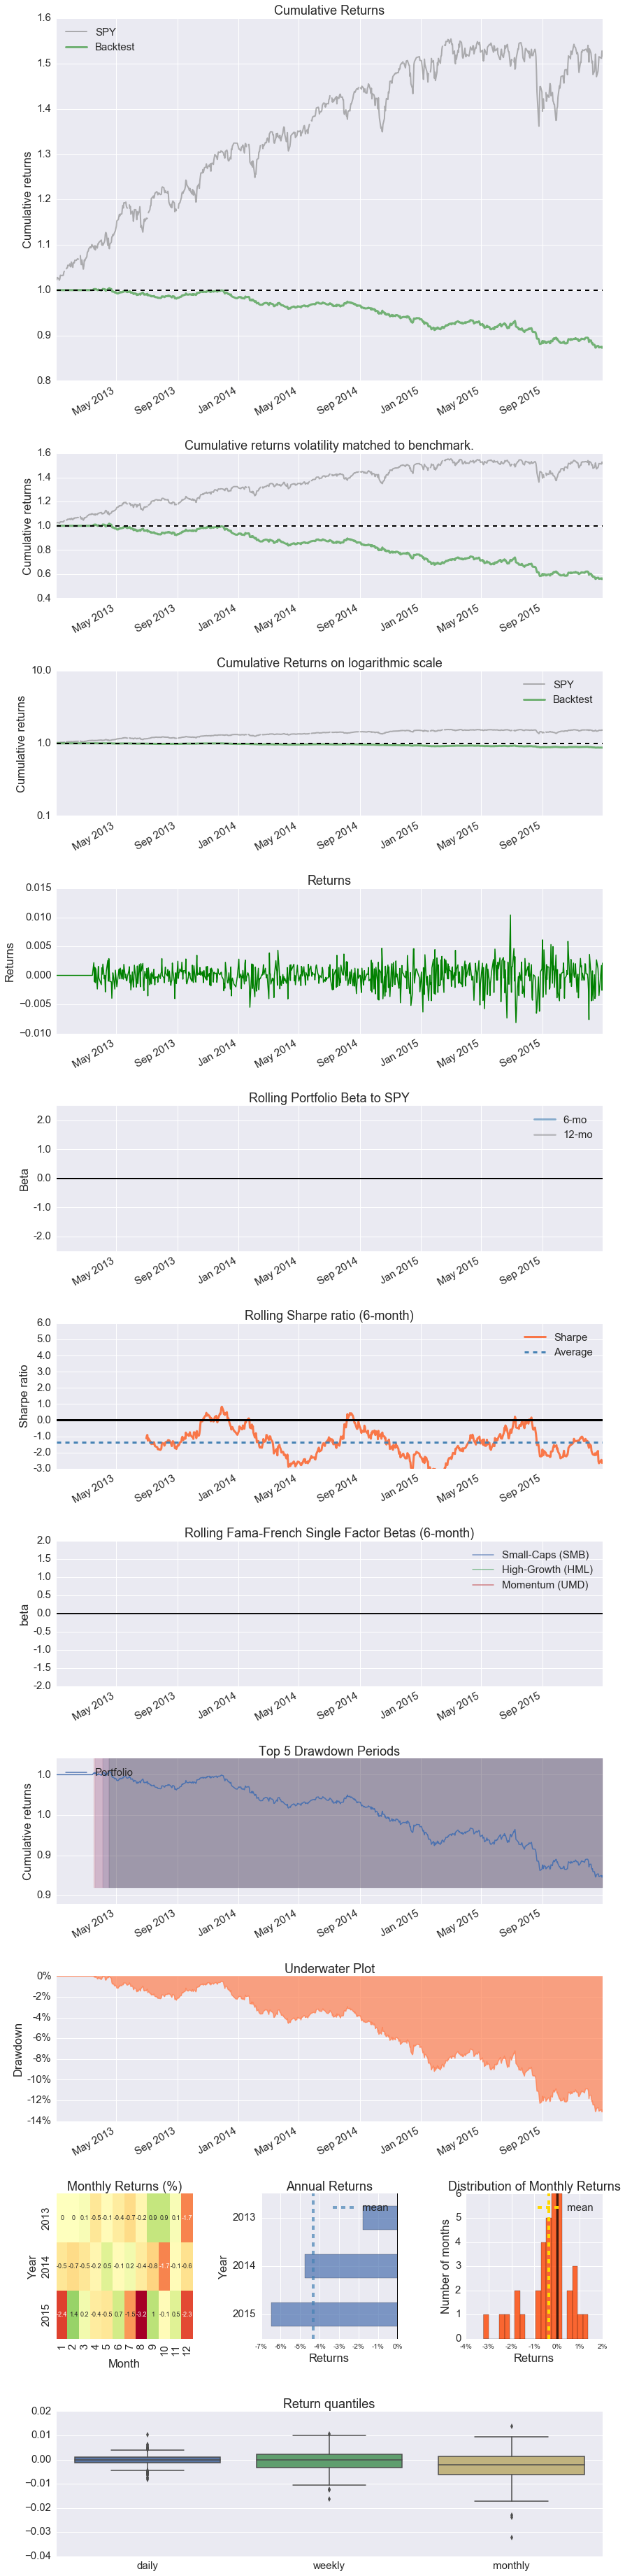

D:\dro\bin\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
Apr14,-0.01%,-0.40%,0.19%
Oct14,-0.07%,-0.43%,0.47%
Fall2015,-0.06%,-0.65%,0.61%
New Normal,-0.02%,-0.81%,1.04%


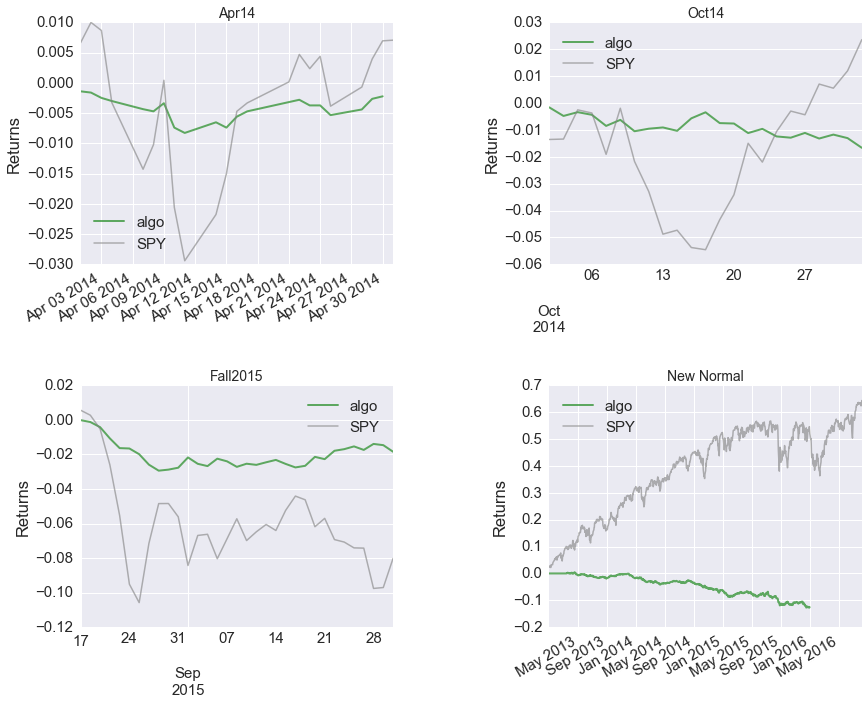

Top 10 long positions of all time,max
Data0,20.09%


Top 10 short positions of all time,max
Data0,-33.18%


Top 10 positions of all time,max
Data0,33.18%


All positions ever held,max
Data0,33.18%


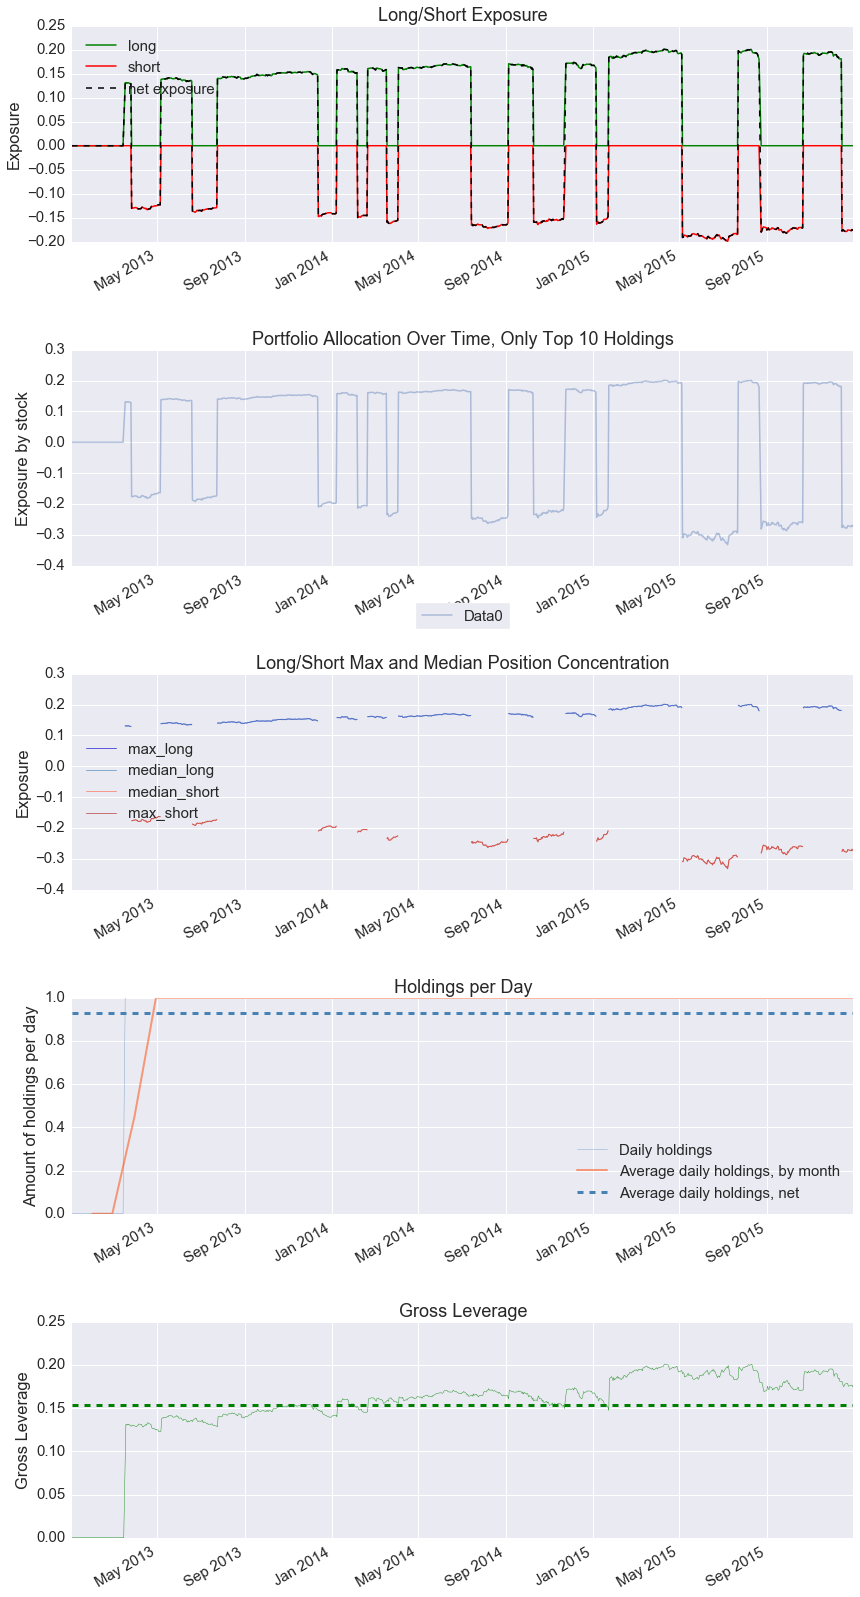

D:\dro\bin\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pyfolio\plotting.py:1210: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  **kwargs)


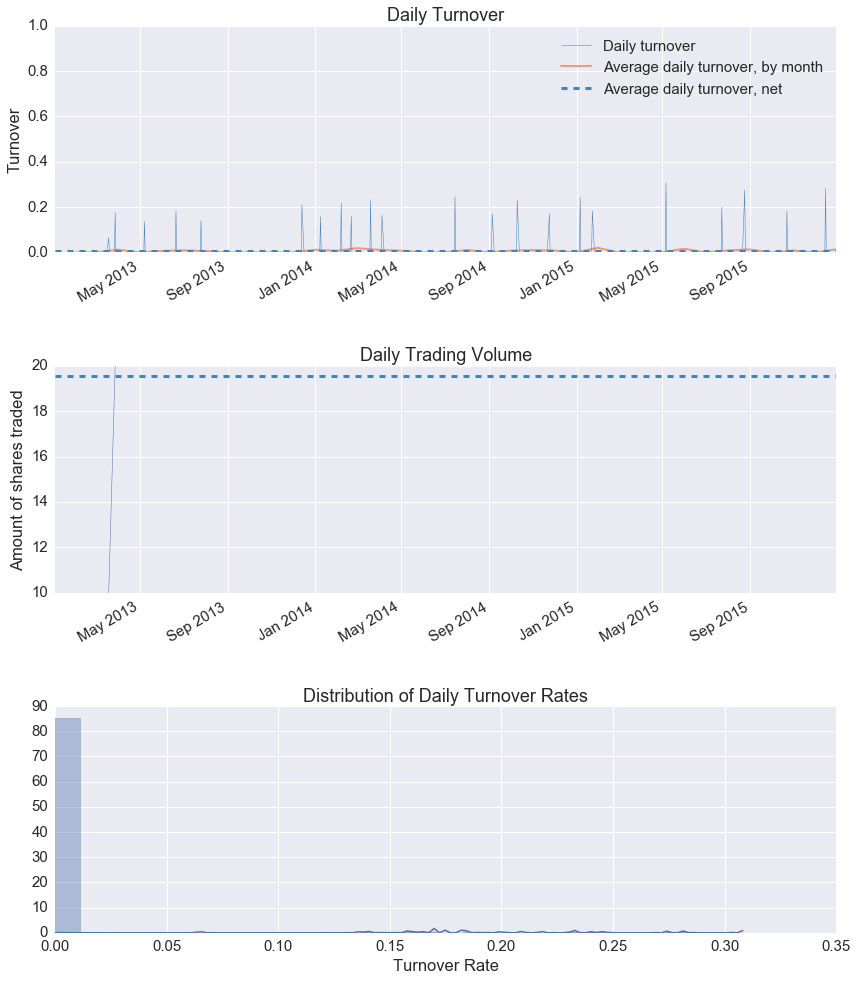

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,22.00,11.00,11.00
Percent profitable,0.18,0.09,0.27
Winning round_trips,4.00,1.00,3.00
Losing round_trips,18.00,10.00,8.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-23220.00,$-14110.00,$-9110.00
Gross profit,$4620.00,$930.00,$3690.00
Gross loss,$-27840.00,$-15040.00,$-12800.00
Profit factor,$0.17,$0.06,$0.29
Avg. trade net profit,$-1055.45,$-1282.73,$-828.18
Avg. winning trade,$1155.00,$930.00,$1230.00
Avg. losing trade,$-1546.67,$-1504.00,$-1600.00
Ratio Avg. Win:Avg. Loss,$0.75,$0.62,$0.77
Largest winning trade,$1730.00,$930.00,$1730.00
Largest losing trade,$-5160.00,$-3270.00,$-5160.00


Duration stats,All trades,Short trades,Long trades
Avg duration,46 days 05:27:16.409090,36 days 04:21:49.181818,56 days 06:32:43.636363
Median duration,38 days 00:00:00,35 days 00:00:00,43 days 00:00:00
Avg # round_trips per day,0.17,0.17,0.08
Avg # round_trips per month,3.50,3.61,1.75


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,-0.74%,-0.80%,-0.68%
Avg returns winning,0.98%,nan%,0.98%
Avg returns losing,-1.02%,-0.80%,-1.30%
Median returns all round_trips,-0.67%,-0.68%,-0.60%
Median returns winning,1.24%,nan%,1.24%
Median returns losing,-0.69%,-0.68%,-0.85%
Largest winning trade,1.44%,-0.40%,1.44%
Largest losing trade,-4.51%,-1.79%,-4.51%


Symbol stats,Data0
Avg returns all round_trips,-0.74%
Avg returns winning,0.98%
Avg returns losing,-1.02%
Median returns all round_trips,-0.67%
Median returns winning,1.24%
Median returns losing,-0.69%
Largest winning trade,1.44%
Largest losing trade,-4.51%


Profitability (PnL / PnL total) per name,pnl
symbol,
Data0,1.00%


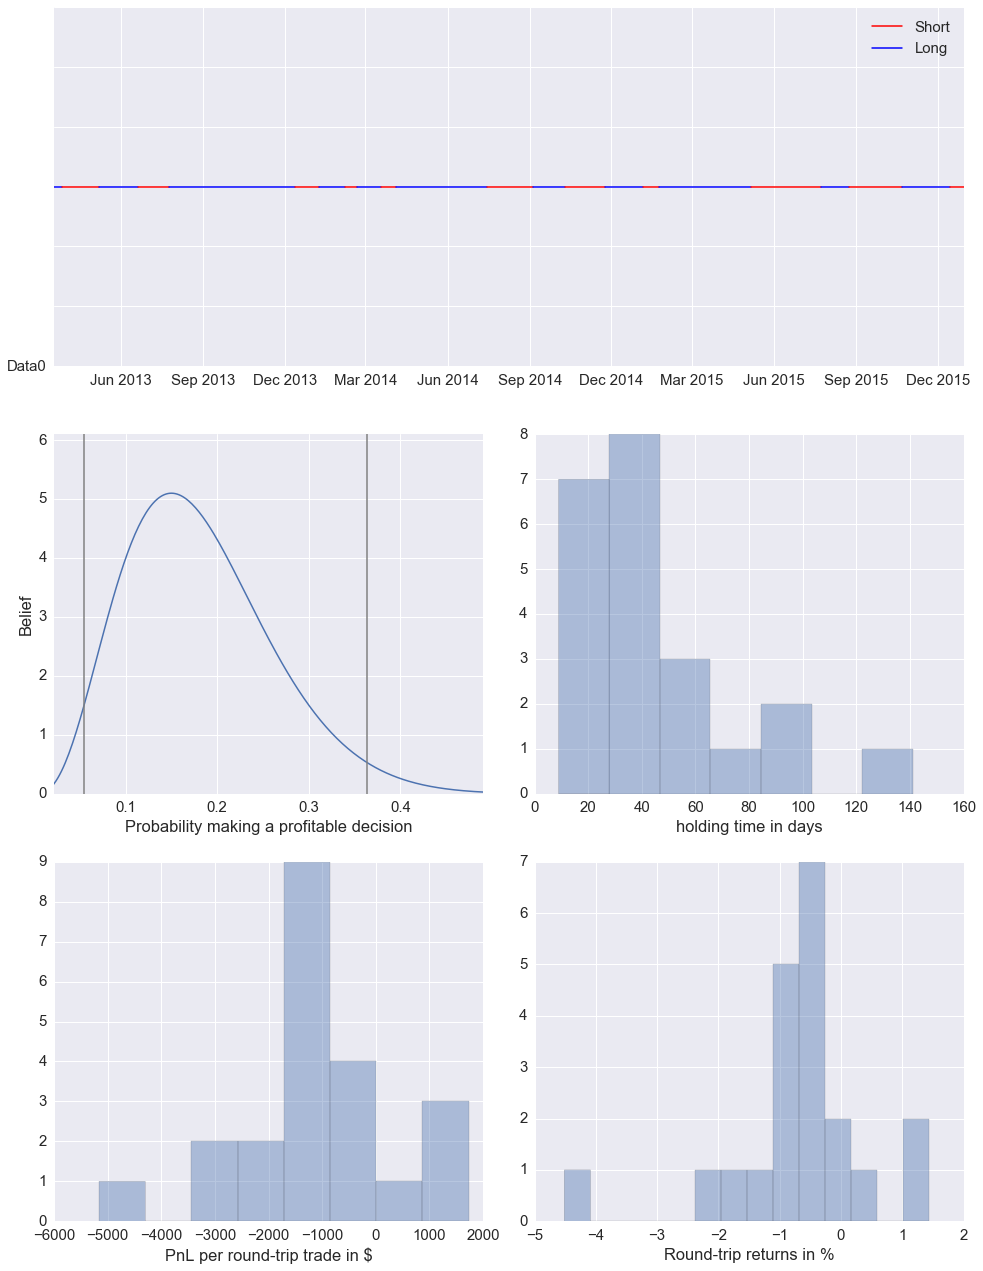

In [3]:
runstrat('--data0 015ES --timeframe days --compression 1 --pyfolio --printout --cash 200000 --short'.split())